# Simulation with Pan-UKBB LD panel

Simulation script

In [ ]:
# ml julia/1.8.4
# export JULIA_DEPOT_PATH="/home/groups/sabatti/.julia"

using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using DataFrames, CSV
using DelimitedFiles
using GLM
using JLD2
using HDF5

# rep_threshold = representative cutoff value
# 1 = every variable selected, 0 = one variable selected in each group
function run_group_knockoff(seed::Int, rep_threshold::Float64, chr, start_pos, end_pos)
    simdir = "/home/groups/sabatti/group_knockoff_simulations/pan_ukbb"
    outdir = joinpath(simdir, "c$(rep_threshold)", "sim$seed")
    isdir(outdir) || mkpath(outdir)

    # parameters
    n = 250
    k = 50
    m = 5
    knockoff_methods = [:equi, :sdp, :maxent, :mvr]
    target_fdrs = collect(0.01:0.01:0.2)

    # read a region of LD into memory
    knockoff_dir = "/oak/stanford/groups/zihuai/pan_ukb_group_knockoffs/EUR"
    LD = JLD2.load(joinpath(knockoff_dir, "chr$chr/LD_start$(start_pos)_end$(end_pos).h5"))
    Σ = LD["Sigma"]
    p = size(Σ, 1)
    μ = zeros(p)

    # simulate X
    Random.seed!(seed)
#     X = rand(MvNormal(Symmetric(Σ)), n)' |> Matrix{Float64}
    L = cholesky(Symmetric(Σ))
    X = randn(n, p) * L.L
    zscore!(X, mean(X, dims=1), std(X, dims=1))

    # simulate y and beta
    βtrue = zeros(p)
    βtrue[1:k] .= randn(k) # rand(Normal(0, 0.5), k)
    shuffle!(βtrue)
    ϵ = randn(n)
    y = X * βtrue + ϵ

    # define group
    groups = LD["groups"]
    correct_groups = groups[findall(!iszero, βtrue)] |> unique

    for method in knockoff_methods
        df = DataFrame(power=Float64[], fdr=Float64[], 
            time=Float64[], ssum=Float64[], obj=Float64[], mineval=Float64[])

        # generate knockoffs
        my_t = @elapsed begin
            0 < rep_threshold <= 1 || error("expected rep_threshold ∈ (0, 1]")
            if rep_threshold == 1
                ko = modelX_gaussian_group_knockoffs(X, method, groups, μ, Σ, m=m)
            else
                ko = modelX_gaussian_rep_group_knockoffs(X, method, groups, μ, Σ, 
                        m=m, rep_threshold=rep_threshold)
            end
        end

        # knockoff filter
        ko_filter = fit_lasso(y, ko, fdrs=target_fdrs)
        my_ssum = sum(abs.(ko.S))
        my_obj = ko.obj
        constraint = eigmin(Symmetric((m+1)/m*Σ - ko.S))
        if constraint < -0.0001
            error("min eval of (m+1)/m*Σ - S) is less than -0.0001")
        end

        # save output
        for (i, fdr) in enumerate(target_fdrs)
            selected = ko_filter.selected[i]
            my_power = length(intersect(correct_groups, selected)) / length(correct_groups)
            my_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            println("sim $seed $method fdr $fdr: power = $(my_power), fdr = $(my_fdr), time = $(my_t), ssum = $(my_ssum), obj=$(my_obj), min eval = $constraint")
            push!(df, [my_power, my_fdr, my_t, my_ssum, my_obj, constraint])
        end
        CSV.write(joinpath(outdir, "$(method)_$(rep_threshold).csv"), df)
    end
end

# input parameters
# seed = 1116
seed = parse(Int, ARGS[1])

# select a random region to work with
Random.seed!(seed)
region_file = "/oak/stanford/groups/zihuai/pan_ukb_LD_matrices/LD_block/EUR_hg19/fourier_ls-all.bed"
df = CSV.read(region_file, DataFrame)
region = rand(1:size(df, 1))
chr = parse(Int, rstrip(df[region, 1])[4:end])
start_pos = df[region, 2]
end_pos = df[region, 3] - 1

for rep_threshold in [0.25, 0.5, 0.75, 1.0]
    @time run_group_knockoff(seed, rep_threshold, chr, start_pos, end_pos)
end
println("finished")


submission scripts

In [31]:
function run_repeats()
    outdir = "/home/groups/sabatti/group_knockoff_simulations"
    for sim in 101:500
        # create .sh file to submit jobs
        filename = "submit.sh"
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=ukb$sim")
            println(io, "#")
            println(io, "#SBATCH --time=24:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=8G")
            println(io, "#SBATCH --partition=owners,normal,candes,zihuai")
            println(io, "#SBATCH --output=$(outdir)/pan_ukbb/slurms/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(outdir)/run_ukb.jl $sim'")
            println(io, "julia $(outdir)/run_ukb.jl $sim")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        println("submitted sim$sim") 
        rm(filename, force=true)
    end
end
run_repeats()


Submitted batch job 27856866
submitted sim101
Submitted batch job 27856868
submitted sim102
Submitted batch job 27856871
submitted sim103
Submitted batch job 27856873
submitted sim104
Submitted batch job 27856875
submitted sim105
Submitted batch job 27856877
submitted sim106
Submitted batch job 27856879
submitted sim107
Submitted batch job 27856881
submitted sim108
Submitted batch job 27856883
submitted sim109
Submitted batch job 27856885
submitted sim110
Submitted batch job 27856887
submitted sim111
Submitted batch job 27856890
submitted sim112
Submitted batch job 27856893
submitted sim113
Submitted batch job 27856895
submitted sim114
Submitted batch job 27856898
submitted sim115
Submitted batch job 27856901
submitted sim116
Submitted batch job 27856904
submitted sim117
Submitted batch job 27856907
submitted sim118
Submitted batch job 27856910
submitted sim119
Submitted batch job 27856912
submitted sim120
Submitted batch job 27856914
submitted sim121
Submitted batch job 27856917
submi

Submitted batch job 27857340
submitted sim280
Submitted batch job 27857343
submitted sim281
Submitted batch job 27857344
submitted sim282
Submitted batch job 27857346
submitted sim283
Submitted batch job 27857348
submitted sim284
Submitted batch job 27857351
submitted sim285
Submitted batch job 27857354
submitted sim286
Submitted batch job 27857357
submitted sim287
Submitted batch job 27857359
submitted sim288
Submitted batch job 27857361
submitted sim289
Submitted batch job 27857364
submitted sim290
Submitted batch job 27857366
submitted sim291
Submitted batch job 27857368
submitted sim292
Submitted batch job 27857370
submitted sim293
Submitted batch job 27857373
submitted sim294
Submitted batch job 27857375
submitted sim295
Submitted batch job 27857378
submitted sim296
Submitted batch job 27857381
submitted sim297
Submitted batch job 27857383
submitted sim298
Submitted batch job 27857385
submitted sim299
Submitted batch job 27857389
submitted sim300
Submitted batch job 27857391
submi

Submitted batch job 27857828
submitted sim459
Submitted batch job 27857831
submitted sim460
Submitted batch job 27857833
submitted sim461
Submitted batch job 27857835
submitted sim462
Submitted batch job 27857837
submitted sim463
Submitted batch job 27857839
submitted sim464
Submitted batch job 27857841
submitted sim465
Submitted batch job 27857844
submitted sim466
Submitted batch job 27857846
submitted sim467
Submitted batch job 27857848
submitted sim468
Submitted batch job 27857850
submitted sim469
Submitted batch job 27857852
submitted sim470
Submitted batch job 27857855
submitted sim471
Submitted batch job 27857858
submitted sim472
Submitted batch job 27857861
submitted sim473
Submitted batch job 27857864
submitted sim474
Submitted batch job 27857867
submitted sim475
Submitted batch job 27857870
submitted sim476
Submitted batch job 27857872
submitted sim477
Submitted batch job 27857875
submitted sim478
Submitted batch job 27857879
submitted sim479
Submitted batch job 27857881
submi

## Make plots

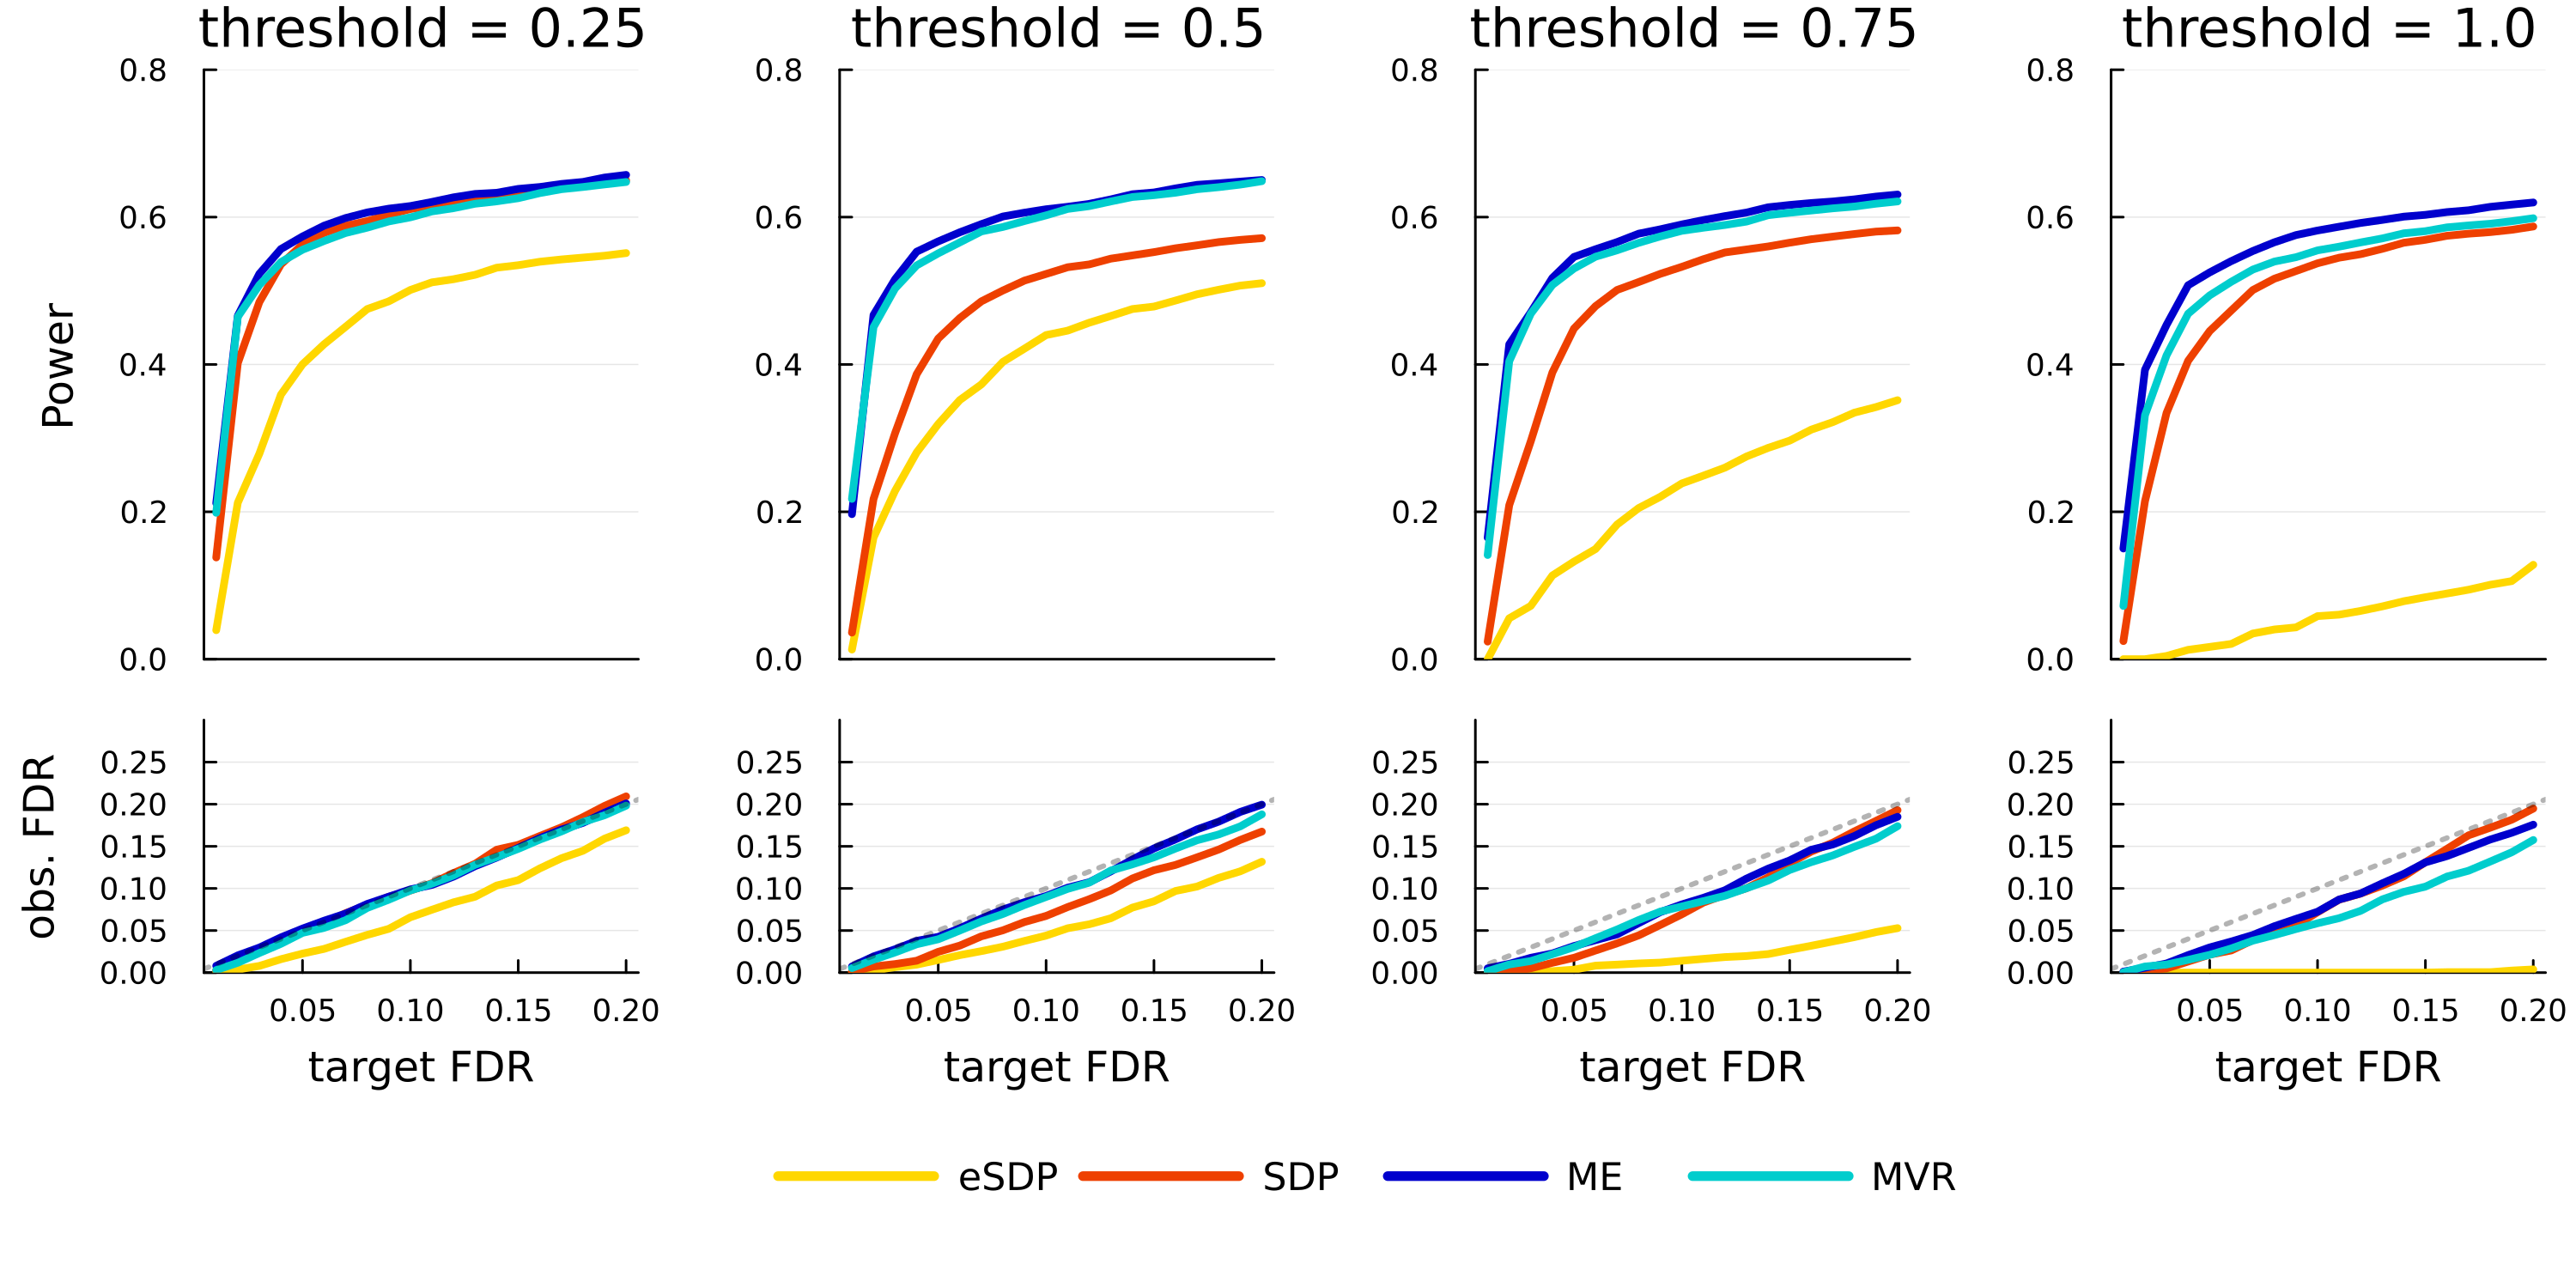

┌ Warning: n° of legend_column=5 is larger than n° of series=4
└ @ Plots /home/groups/sabatti/.julia/packages/Plots/rz1WP/src/backends/gr.jl:1235
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [30]:
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
using Statistics
gr(fmt=:png);

global my_colors = ["gold", "orangered2", "mediumblue", "cyan3"]

function summarize_ukb(method, rep_threshold, target_fdrs = 0.01:0.01:0.2)
    dir = "/home/groups/sabatti/group_knockoff_simulations/pan_ukbb/c$(rep_threshold)"
    powers = zeros(length(target_fdrs))
    fdrs = zeros(length(target_fdrs))
    success = 0
    for seed in 1:500
        try
            result = CSV.read(joinpath(dir, "sim$seed", "$(method)_$(rep_threshold).csv"), DataFrame)
            powers .+= result[1:length(target_fdrs), 1]
            fdrs .+= result[1:length(target_fdrs), 2]
            success += 1
        catch
            continue
        end
    end
#     @show success
    powers ./= success
    fdrs ./= success
    return powers, fdrs
end

function make_plot_ukb(rep_threshold; target_fdrs = 0.01:0.01:0.2)
    ko_methods = ["equi", "sdp", "maxent", "mvr"]
    ko_labels = ["Equi", "SDP", "ME", "MVR"]

    # output plots
    title = "threshold = $rep_threshold"
    if rep_threshold == 0.25
        power_plt = plot(; title = title, xtick=false, ylim=(0, 0.8), ylabel="Power",legend=false)
        fdr_plt = plot(; xlabel="target FDR", ylim=(0, 0.3), ylabel="obs. FDR", legend=false, xgrid=false)
    else
        power_plt = plot(; title = title, ylim=(0, 0.8), 
            legend=false, xtick=false)#, ytick=(0.0:0.2:0.8, ["", "", "", "", ""]))
        fdr_plt = plot(; xlabel="target FDR", ylim=(0, 0.3), legend=false, xgrid=false)
    end

    # loop over knockoff results
    for (i, method) in enumerate(ko_methods)
        label = ko_labels[i]
        power, fdr = summarize_ukb(method, rep_threshold)
        plot!(power_plt, target_fdrs, power, label=label, w=3, color=my_colors[i])
        plot!(fdr_plt, target_fdrs, fdr, w=3, label="", color=my_colors[i])
    end
    Plots.abline!(fdr_plt, 1, 0, alpha=0.3, w=2, linestyle=:dot, color=:black)#, label="Expected FDR")

    return power_plt, fdr_plt
end

# group/rep-group plots
plts = []
for rep_threshold in [0.25, 0.5, 0.75, 1.0]
    ukb_power_plt, ukb_fdr_plt = make_plot_ukb(rep_threshold)
    plt = plot(ukb_power_plt, ukb_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))
    push!(plts, plt)
end

# separate plot for legend
n = 5
labels = ["eSDP" "SDP" "ME" "MVR"]
lstyles = [:solid :solid :solid :solid]
legend_plt = plot(2:n,2:n, lims=(0,1), legendfontsize=10, legend=:outerbottom, 
    legendcolumns=n, frame=:none, fg_color_legend = nothing, w=3,
    label=labels[1], color=my_colors[1], linestyle=lstyles[1])
plot!(legend_plt, 2:n, 2:n, label=labels[2], color=my_colors[2], w=3,linestyle=lstyles[2])
plot!(legend_plt, 2:n, 2:n, label=labels[3], color=my_colors[3], w=3,linestyle=lstyles[3])
plot!(legend_plt, 2:n, 2:n, label=labels[4], color=my_colors[4], w=3,linestyle=lstyles[4])
# plot!(legend_plt, 2:n, 2:n, label="target FDR", color="black", alpha=0.3, w=2, linestyle=:dot)

# combine plots
combined = plot(plts..., size=(1000, 500), layout=(1, 4))
plt = plot(combined, legend_plt, layout = grid(2, 1, heights=[0.89, 0.11]), 
    dpi=300, left_margin = 5Plots.mm)

In [26]:
savefig(plt, "/home/users/bbchu/knockoffs/plots/sim2.pdf")

┌ Warning: n° of legend_column=5 is larger than n° of series=4
└ @ Plots /home/groups/sabatti/.julia/packages/Plots/rz1WP/src/backends/gr.jl:1235
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/home/users/bbchu/knockoffs/plots/sim2.pdf"